# Detect and Mitigate Machine Learning Pitfalls - Confounding

In [18]:
# Imports

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


## Part 1 - Preparations and recap

In [4]:
# Get the previously prepared data
repo_base_dir = Path("../..")  # To be adjusted
data_dir = repo_base_dir / "data_downloads"
data_dir.mkdir(parents=True, exist_ok=True)

# load data
df_beh = pd.read_csv(data_dir / 'IXI_behavioural_reuse.csv', index_col=0)
df_brain = pd.read_csv(data_dir / 'GMV_reuse.csv', index_col=0)
print(f"Behavioral data shape: {df_beh.shape}")
print(f"Brain data shape: {df_brain.shape}")
df_beh

Behavioral data shape: (536, 6)
Brain data shape: (536, 116)


,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,DOB,STUDY_DATE,AGE
subjectID,,,,,,
sub-IXI002,2,164,58,1970-01-30,2005-11-18,35.800137
sub-IXI012,1,175,70,1966-08-20,2005-06-01,38.781656
sub-IXI013,1,182,70,1958-09-15,2005-06-01,46.710472
sub-IXI014,2,163,65,1971-03-15,2005-06-09,34.236824
sub-IXI015,1,181,90,1981-03-11,2005-06-23,24.284736
...,...,...,...,...,...,...
sub-IXI648,1,193,120,1959-03-08,2006-11-27,47.723477
sub-IXI651,1,175,61,1956-07-09,2006-12-01,50.395619
sub-IXI652,1,163,80,1963-12-05,2006-12-01,42.989733


In [ ]:
# Check for NaNs in confounding columns
confounding_cols = ["SEX_ID (1=m, 2=f)", "AGE"]
for col in confounding_cols:
    if df_beh[col].isna().sum() > 0:
        print(f"{df_beh[col].isna().sum()} NaNs in confounding column {col}.")
        print("Drop NaNs and align subjects")
        df_beh = df_beh.dropna()
        df_brain = df_brain.loc[df_beh.index]
        print(f"New behavioral data shape: {df_beh.shape}")
        print(f"New brain data shape: {df_brain.shape}")
    else:
        print(f"No NaNs in confounding column {col}.")

No NaNs in confounding column SEX_ID (1=m, 2=f)
3 NaNs in AGE.
Drop NaNs and align subjects
New behavioral data shape: (533, 6)
New brain data shape: (533, 116)


In [27]:
# Redo the same ridge model as before but with full manually implemented nested CV

y = df_beh['HEIGHT'].values
X = df_brain.values  # only brain features
GMV_columns = df_brain.columns

# CV schemes
n_outer = 5
n_inner = 5
outer_cv = KFold(n_splits=n_outer, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=n_inner, shuffle=True, random_state=42)

# hyperparameter grid
alphas = [0.001, 0.1, 0.5, 1.0, 10.0]

# initialize lists to store results
outer_results = []
best_alphas_outer = []

# loop over outer CV folds
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}")

    X_outer_train, X_outer_test = X[outer_train_idx], X[outer_test_idx]
    y_outer_train, y_outer_test = y[outer_train_idx], y[outer_test_idx]

    # Inner CV scheme
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # --------- inner CV for hyperparameter tuning ---------
    alpha_scores = {alpha: [] for alpha in alphas}

    # iterate inner folds for hyperparameter evaluation
    for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train, y_outer_train):
        X_inner_train, X_inner_val = X_outer_train[inner_train_idx], X_outer_train[inner_val_idx]
        y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]

        # Standardize features
        scaler_inner = StandardScaler()
        X_inner_train_scaled = scaler_inner.fit_transform(X_inner_train)
        X_inner_val_scaled = scaler_inner.transform(X_inner_val)

        # For each alpha, train Ridge on inner_train and evaluate on inner_val
        for alpha in alphas:
            model = Ridge(alpha=alpha)
            model.fit(X_inner_train_scaled, y_inner_train)
            y_val_pred = model.predict(X_inner_val_scaled)
            R2_val = r2_score(y_inner_val, y_val_pred)  # you can also use other metrics
            alpha_scores[alpha].append(R2_val)
    
    # Aggregate inner scores (mean across inner folds) - median can also be a suitable choice
    mean_alpha_scores = {alpha: np.mean(alpha_scores[alpha]) for alpha in alphas}
    # pick the alpha with the highest mean inner CV R2
    best_alpha = max(sorted(alphas), key=lambda x: mean_alpha_scores[x])
    best_alphas_outer.append(best_alpha)

    # ---------- retrain on full outer training set with best alpha and evaluate on outer test set ----------
    # Fit scaler on outer training set
    scaler_outer = StandardScaler()
    X_outer_train_scaled = scaler_outer.fit_transform(X_outer_train)
    X_outer_test_scaled = scaler_outer.transform(X_outer_test)

    # Train Ridge with best alpha on full outer training set
    model_outer = Ridge(alpha=best_alpha).fit(X_outer_train_scaled, y_outer_train)

    # Evaluate on outer test set
    y_outer_test_pred = model_outer.predict(X_outer_test_scaled)
    R2_outer_test = r2_score(y_outer_test, y_outer_test_pred)
    r_test = np.corrcoef(y_outer_test, y_outer_test_pred)[0, 1]
    print(f"  Best alpha: {best_alpha}")
    print(f"  Outer Test R²: {R2_outer_test:.3f}")
    print(f"  Outer Test Pearson r: {r_test:.3f}")

    # Evaluate train performance on outer_train (to check for overfitting)
    y_outer_train_pred = model_outer.predict(X_outer_train_scaled)
    R2_outer_train = r2_score(y_outer_train, y_outer_train_pred)
    r_train = np.corrcoef(y_outer_train, y_outer_train_pred)[0, 1]
    print(f"  Outer Train R²: {R2_outer_train:.3f}")
    print(f"  Outer Train Pearson r: {r_train:.3f}")    

    # Store all relevant info for this outer fold
    outer_results.append({
        "fold": outer_fold,
        "best_alpha": best_alpha,
        "R2_train": R2_outer_train,
        "R2_test": R2_outer_test,
        "r_train": r_train,
        "r_test": r_test,
        "model": model_outer,
        "scaler": scaler_outer,
        "X_train_idx": outer_train_idx,
        "X_test_idx": outer_test_idx
    })

    print(f"----- Done with outer fold {outer_fold+1} ------\n")

# Summary
mean_test_r2 = np.mean([res['R2_test'] for res in outer_results])
mean_test_r = np.mean([res['r_test'] for res in outer_results])
mean_train_r2 = np.mean([res['R2_train'] for res in outer_results])
mean_train_r = np.mean([res['r_train'] for res in outer_results])
print(
    f"\nNested CV summary over {n_outer} folds: \n"
    f"mean R2_test={mean_test_r2:.3f}, mean r_test={mean_test_r:.3f}, \n"
    f"mean R2_train={mean_train_r2:.3f}, mean r_train={mean_train_r:.3f}",
    )
print("Best alphas per outer fold:", best_alphas_outer)

Outer fold 1
  Best alpha: 10.0
  Outer Test R²: 0.191
  Outer Test Pearson r: 0.511
  Outer Train R²: 0.559
  Outer Train Pearson r: 0.749
----- Done with outer fold 1 ------

Outer fold 2
  Best alpha: 10.0
  Outer Test R²: 0.298
  Outer Test Pearson r: 0.581
  Outer Train R²: 0.563
  Outer Train Pearson r: 0.751
----- Done with outer fold 2 ------

Outer fold 3
  Best alpha: 10.0
  Outer Test R²: 0.305
  Outer Test Pearson r: 0.568
  Outer Train R²: 0.545
  Outer Train Pearson r: 0.739
----- Done with outer fold 3 ------

Outer fold 4
  Best alpha: 10.0
  Outer Test R²: 0.398
  Outer Test Pearson r: 0.639
  Outer Train R²: 0.539
  Outer Train Pearson r: 0.736
----- Done with outer fold 4 ------

Outer fold 5
  Best alpha: 10.0
  Outer Test R²: 0.164
  Outer Test Pearson r: 0.475
  Outer Train R²: 0.575
  Outer Train Pearson r: 0.760
----- Done with outer fold 5 ------


Nested CV summary over 5 folds: 
mean R2_test=0.271, mean r_test=0.555, 
mean R2_train=0.556, mean r_train=0.747
B

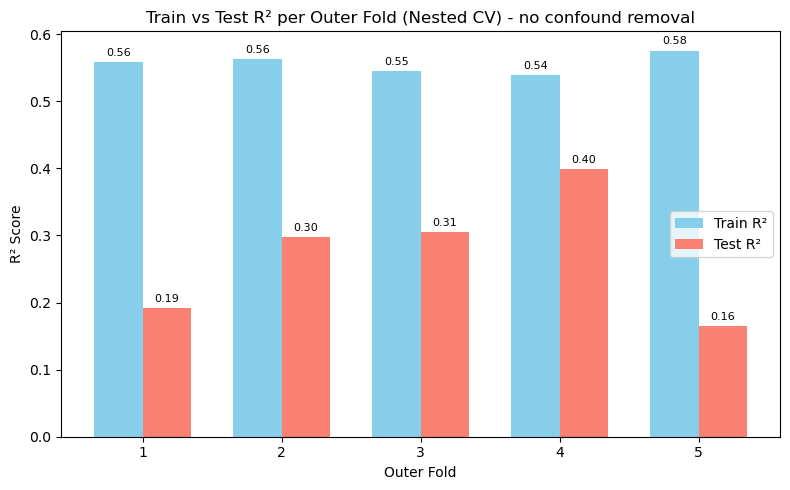

In [28]:
# Compare train and test outer CV performance visually

import matplotlib.pyplot as plt
import numpy as np

# Extract values from results
folds = [res['fold']+1 for res in outer_results]  # fold indices (1-based for nicer labeling)
r2_train = [res['R2_train'] for res in outer_results]
r2_test = [res['R2_test'] for res in outer_results]

x = np.arange(len(folds))  # the label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(x - width/2, r2_train, width, label="Train R²", color="skyblue")
bars2 = ax.bar(x + width/2, r2_test, width, label="Test R²", color="salmon")

# Labels and formatting
ax.set_xlabel("Outer Fold")
ax.set_ylabel("R² Score")
ax.set_title("Train vs Test R² per Outer Fold (Nested CV) - no confound removal")
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.legend()

# Add numbers on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


## Part 2 - Adjusting for confounding

From the DAG we know that one possible minimal set of variables to adjust for would be genetic factors, hormonal factors, maternal health/nutrition, childhood nutrition, childhood health/healthcare, sex and age. However, most of these variables are unmeasured, in fact of this list we only have sex and age measured. While it is still good to adjust for them, we have to keep in mind that we will remain with a partially biased model!

In [39]:
# Do the same nested CV but now adjusting for confounding by linear feature residualization

y = df_beh['HEIGHT'].values
X = df_brain.values  # only brain features
GMV_columns = df_brain.columns
confounds = df_beh[['SEX_ID (1=m, 2=f)','AGE']].values  # ADDTIONAL STEP

# CV schemes
n_outer = 5
n_inner = 5
outer_cv = KFold(n_splits=n_outer, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=n_inner, shuffle=True, random_state=42)

# hyperparameter grid
alphas = [0.001, 0.1, 0.5, 1.0, 10.0]

# initialize lists to store results
outer_results_with_cnfdrm = []
best_alphas_outer_with_cnfdrm = []

# loop over outer CV folds
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}")

    X_outer_train, X_outer_test = X[outer_train_idx], X[outer_test_idx]
    y_outer_train, y_outer_test = y[outer_train_idx], y[outer_test_idx]
    # ADDITIONAL STEP - split the cnfounding variables
    conf_outer_train, conf_outer_test = confounds[outer_train_idx], confounds[outer_test_idx]
    # Sanity check prints
    # print(
    #     f"   Length X_outer_train: {len(X_outer_train)}, "
    #     f"   y_outer_train: {len(y_outer_train)}, "
    #     f"   conf_outer_train: {len(conf_outer_train)}.")
    # print(
    #     f"   Length X_outer_test: {len(X_outer_test)}, "
    #     f"   y_outer_test: {len(y_outer_test)}, "
    #     f"   conf_outer_test: {len(conf_outer_test)}. \n")

    # Inner CV scheme
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # --------- inner CV for hyperparameter tuning ---------
    alpha_scores = {alpha: [] for alpha in alphas}

    # iterate inner folds for hyperparameter evaluation
    for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train, y_outer_train):
        X_inner_train, X_inner_val = X_outer_train[inner_train_idx], X_outer_train[inner_val_idx]
        y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]
        # ADDITIONAL STEP - split confounding variables
        conf_inner_train, conf_inner_val = conf_outer_train[inner_train_idx], conf_outer_train[inner_val_idx]
        # Sanity check prints
        # print(
        #     f"   Length X_inner_train: {len(X_inner_train)}, "
        #     f"   y_inner_train: {len(y_inner_train)}, "
        #     f"   conf_inner_train: {len(conf_inner_train)}.")
        # print(
        #     f"   Length X_inner_val: {len(X_inner_val)}, "
        #     f"   y_inner_val: {len(y_inner_val)}, "
        #     f"   conf_inner_val: {len(conf_inner_val)}. \n")

        # ADDITIONAL STEP - Fit confound model on inner_train (multi-output linear regression)
        conf_model = LinearRegression().fit(conf_inner_train, X_inner_train)  # predict features from confounds

        # ADDITIONAL STEP - Residualize features: subtract confound predictions
        X_inner_train_resid = X_inner_train - conf_model.predict(conf_inner_train)
        X_inner_val_resid = X_inner_val - conf_model.predict(conf_inner_val)

        # Standardize RESIDUALIZED features
        scaler_inner = StandardScaler()
        X_inner_train_res_scaled = scaler_inner.fit_transform(X_inner_train_resid)
        X_inner_val_res_scaled = scaler_inner.transform(X_inner_val_resid)

        # For each alpha, train Ridge on inner_train and evaluate on inner_val
        for alpha in alphas:
            model = Ridge(alpha=alpha)
            model.fit(X_inner_train_res_scaled, y_inner_train)
            y_val_pred = model.predict(X_inner_val_res_scaled)
            R2_val = r2_score(y_inner_val, y_val_pred)  # you can also use other metrics
            alpha_scores[alpha].append(R2_val)
    
    # Aggregate inner scores (mean across inner folds) - median can also be a suitable choice
    mean_alpha_scores = {alpha: np.mean(alpha_scores[alpha]) for alpha in alphas}
    # pick the alpha with the highest mean inner CV R2
    best_alpha = max(sorted(alphas), key=lambda x: mean_alpha_scores[x])
    best_alphas_outer_with_cnfdrm.append(best_alpha)

    # ---------- retrain on full outer training set with best alpha and evaluate on outer test set ----------
    # ADDITIONAL STEP - Fit confound model on entire outer_train
    conf_model_outer = LinearRegression().fit(conf_outer_train, X_outer_train)
    X_outer_train_resid = X_outer_train - conf_model_outer.predict(conf_outer_train)
    X_outer_test_resid = X_outer_test - conf_model_outer.predict(conf_outer_test)

    # Fit scaler on outer training set (on RESIDUALIZED features)
    scaler_outer = StandardScaler()
    X_outer_train_res_scaled = scaler_outer.fit_transform(X_outer_train_resid)
    X_outer_test_res_scaled = scaler_outer.transform(X_outer_test_resid)

    # Train Ridge with best alpha on full outer training set (on RESIDUALIZED features)
    model_outer = Ridge(alpha=best_alpha).fit(X_outer_train_res_scaled, y_outer_train)

    # Evaluate on outer test set
    y_outer_test_pred = model_outer.predict(X_outer_test_res_scaled)
    R2_outer_test = r2_score(y_outer_test, y_outer_test_pred)
    r_test = np.corrcoef(y_outer_test, y_outer_test_pred)[0, 1]
    print(f"  Best alpha (with confound removal): {best_alpha}")
    print(f"  Outer Test R² (with confound removal): {R2_outer_test:.3f}")
    print(f"  Outer Test Pearson r (with confound removal): {r_test:.3f}")

    # Evaluate train performance on outer_train (to check for overfitting)
    y_outer_train_pred = model_outer.predict(X_outer_train_res_scaled)
    R2_outer_train = r2_score(y_outer_train, y_outer_train_pred)
    r_train = np.corrcoef(y_outer_train, y_outer_train_pred)[0, 1]
    print(f"  Outer Train R² (with confound removal): {R2_outer_train:.3f}")
    print(f"  Outer Train Pearson r (with confound removal): {r_train:.3f}")    

    # Store all relevant info for this outer fold
    outer_results_with_cnfdrm.append({
        "fold": outer_fold,
        "best_alpha": best_alpha,
        "R2_train": R2_outer_train,
        "R2_test": R2_outer_test,
        "r_train": r_train,
        "r_test": r_test,
        "model": model_outer,
        "scaler": scaler_outer,
        "X_train_idx": outer_train_idx,
        "X_test_idx": outer_test_idx
    })

    print(f"----- Done with outer fold {outer_fold+1} ------\n")

# Summary
mean_test_r2_withcnfdrm = np.mean([res['R2_test'] for res in outer_results_with_cnfdrm])
mean_test_r_withcnfdrm = np.mean([res['r_test'] for res in outer_results_with_cnfdrm])
mean_train_r2_withcnfdrm = np.mean([res['R2_train'] for res in outer_results_with_cnfdrm])
mean_train_r_withcnfdrm = np.mean([res['r_train'] for res in outer_results_with_cnfdrm])
print(
    f"\nNested CV summary over {n_outer} folds (with confound removal): \n"
    f"mean R2_test={mean_test_r2_withcnfdrm:.3f}, mean r_test={mean_test_r_withcnfdrm:.3f}, \n"
    f"mean R2_train={mean_train_r2_withcnfdrm:.3f}, mean r_train={mean_train_r_withcnfdrm:.3f}",
    )
print("Best alphas per outer fold (with confound removal):", best_alphas_outer_with_cnfdrm)

Outer fold 1
  Best alpha (with confound removal): 10.0
  Outer Test R² (with confound removal): -0.289
  Outer Test Pearson r (with confound removal): 0.030
  Outer Train R² (with confound removal): 0.178
  Outer Train Pearson r (with confound removal): 0.424
----- Done with outer fold 1 ------

Outer fold 2
  Best alpha (with confound removal): 10.0
  Outer Test R² (with confound removal): -0.080
  Outer Test Pearson r (with confound removal): 0.137
  Outer Train R² (with confound removal): 0.181
  Outer Train Pearson r (with confound removal): 0.426
----- Done with outer fold 2 ------

Outer fold 3
  Best alpha (with confound removal): 10.0
  Outer Test R² (with confound removal): -0.049
  Outer Test Pearson r (with confound removal): 0.146
  Outer Train R² (with confound removal): 0.140
  Outer Train Pearson r (with confound removal): 0.375
----- Done with outer fold 3 ------

Outer fold 4
  Best alpha (with confound removal): 10.0
  Outer Test R² (with confound removal): 0.061
  O

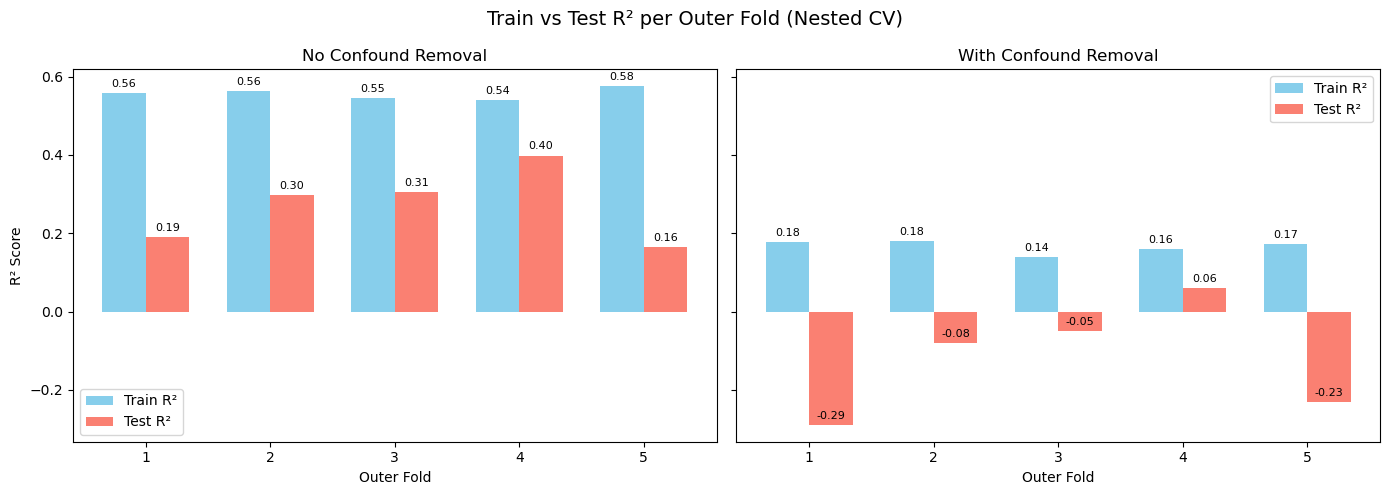

In [40]:
# Visual comparison of train and test outer CV performance with and without confound removal

import matplotlib.pyplot as plt
import numpy as np

# --- Extract values ---
# Non-confound adjusted
folds = [res['fold']+1 for res in outer_results]
r2_train_no = [res['R2_train'] for res in outer_results]
r2_test_no = [res['R2_test'] for res in outer_results]

# Confound adjusted
folds_cnf = [res['fold']+1 for res in outer_results_with_cnfdrm]
r2_train_cnf = [res['R2_train'] for res in outer_results_with_cnfdrm]
r2_test_cnf = [res['R2_test'] for res in outer_results_with_cnfdrm]

# --- Plot ---
x = np.arange(len(folds))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Left subplot: No confound removal ---
ax = axes[0]
bars1 = ax.bar(x - width/2, r2_train_no, width, label="Train R²", color="skyblue")
bars2 = ax.bar(x + width/2, r2_test_no, width, label="Test R²", color="salmon")
ax.set_title("No Confound Removal")
ax.set_xlabel("Outer Fold")
ax.set_ylabel("R² Score")
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.legend()

# Add numbers on top
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)

# --- Right subplot: With confound removal ---
ax = axes[1]
bars1 = ax.bar(x - width/2, r2_train_cnf, width, label="Train R²", color="skyblue")
bars2 = ax.bar(x + width/2, r2_test_cnf, width, label="Test R²", color="salmon")
ax.set_title("With Confound Removal")
ax.set_xlabel("Outer Fold")
ax.set_xticks(x)
ax.set_xticklabels(folds_cnf)
ax.legend()

# Add numbers on top
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)

plt.suptitle("Train vs Test R² per Outer Fold (Nested CV)", fontsize=14)
plt.tight_layout()
plt.show()


**Question**:
1. What do you take from this plot?
2. Would you make any adjustments to your modeling setup, if so which and whz, if not, why not?